This is a quick demonstration of the neural network implementation given in this repository. We use the well known MNIST handwritten numeral dataset, which consists of 28 pixel by 28 pixel images of handwritten numerals from 0 to 9. The data thus has 784 features, each being an intensity value from 0 (white) to 255 (black). There are 70000 images in total.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame, Series
from scipy.special import expit
from scipy.optimize import fmin_cg
%matplotlib inline

The code is included here for reference. We will only be calling the train_network function, and the predict method from the NeuralNetModel class. 

In [2]:
class NeuralNetModel():
    """ Output of a neural network training algorithm."""
    def __init__(self, neural_network):
        self._network = neural_network
        
    def get_weights(self):
        """ Return the weights used by the model to make predictions."""
        return self._network.weights
    
    def predict(self, X):
        """ Classify the observations in X.
        
        Args: 
            X (array): data to be classified. 
        Returns:
            array: each entry is the class assigned to the corresponding
            row in X.
        Raises:
            ValueError: if the features in X do not match the model. 
        """
        
        num_features = self._network.layers[0]
        if not X.shape[1] == num_features:
            raise ValueError("Number of features in data must be {0}."
                             .format(num_features))
        forward_propogate(self.get_weights(), X, self._network)
        class_predictions = self._network.get_final_activation()
        return np.argmax(class_predictions, axis = 1)
    
    def __repr__(self):
        return("Trained neural network with {0} hidden layers of size(s) {1}."
               .format(len(self._network.layers)-2, self._network.layers[1:-1]))

class NeuralNetwork():
    """ Internal network class to keep track of its properties."""
    def __init__(self, layer_sizes):
        self.layers = layer_sizes
        self._shapes = []
        self.activations = []
        self.raw_outputs = []
        self._initialize_shapes()
        self.weights = None
        
    def num_transitions(self):
        """ Return the number of transitions between layers."""
        return len(self.layers) - 1
    
    def get_final_activation(self):
        """ Return the last activation, giving the current probabilities."""
        return self.activations[self.num_transitions()]
        
    def _initialize_shapes(self):
        """ Determine the shapes for the weights in the network."""
        for index in range(self.num_transitions()):
            input_size = self.layers[index]
            output_size = self.layers[index+1]
            shape = (output_size, 1 + input_size)
            self._shapes.append(shape)
    
    def initialize_weights(self):
        """ Return random initial weights according to this network's shapes."""
        weights = []
        for index in range(self.num_transitions()):
            init_epsilon = self._get_initial_epsilon(index)
            shape_x, shape_y = self._shapes[index]
            weight = init_epsilon * (np.random.rand(shape_x, shape_y) * 2 - 1)
            weights.append(weight)
        return weights
        
    def _get_initial_epsilon(self, index):
        """ Return scaling factor for initialized weights."""
        input_size = self.layers[index]
        output_size = self.layers[index+1]
        return (6 / (input_size + output_size))**(1/2)
        
    def reshape_weights(self, flat_weights):
        """ Restore shape of weights according to this network's shapes."""
        start_index = 0
        shaped_weights = []
        for shape in self._shapes:
            matrix_size = shape[0] * shape[1]
            end_index = start_index + matrix_size
            shaped_weights.append(flat_weights[start_index:end_index].reshape(shape))
            start_index = end_index
        return shaped_weights
        
def train_network(X, Y, layers, regularization = 0, max_iters = 200):
    """ Train a neural network and return the model.
    
    Args:
        X (array): data consisting of rows of features. 
        Y (array): array of labels corresponding to each row in X.
            Must consist of integers from 0 to n for some integer n.
        layers (list): the number of features in each layer. The first
            entry must be the number of features (columns) in X, the 
            last must be the number of classes, and those inbetween
            determine the size of each hidden layer.
        regularization (int): penalty factor for having larger weights.
            (defualt: 0).
        max_iters (int): the max number of iterations used by the algorithm
            when searching for optimal weights. A higher number will produce
            a better fit but extends run time (default: 200).
    """
    check_input_validity(X, Y, layers)
    num_classes = layers[-1]
    network = NeuralNetwork(layers)
    initial_weights = flatten_weights(network.initialize_weights()) 
    Y = process_labels(Y, num_classes)
    optimal = fmin_cg(compute_cost, 
                      initial_weights, 
                      back_propogate, 
                      args = (X, Y, network, regularization), 
                      maxiter = max_iters)
    forward_propogate(network.reshape_weights(optimal), X, network)
    network.weights = network.reshape_weights(optimal)
    return NeuralNetModel(network)
    
def compute_cost(flat_weights, X, label_matrix, network, regularization):
    """ Propogate weights through network and compute cost function."""
    weights = network.reshape_weights(flat_weights)
    forward_propogate(weights, X, network)
    return cost_function(weights, label_matrix, network, regularization)
    
def forward_propogate(weights, X, network):
    """ Perform forward propogation on the given network and dataset."""
    raw_outputs = [X]
    activations = [X]
    for i in range(network.num_transitions()):
        activations[i] = insert_ones(activations[i])
        weight = weights[i]
        raw_output = activations[i].dot(weight.transpose())
        activation = sigmoid(raw_output)
        raw_outputs.append(raw_output)
        activations.append(activation)
    network.activations = activations
    network.raw_outputs = raw_outputs
        
def cost_function(weights, label_matrix, network, regularization):
    """ Compute the cost function for the network's current state."""
    a = network.get_final_activation()
    Y = label_matrix
    m = len(label_matrix)
    weight_sum = 0
    for weight in weights:
        weight_sum += (weight[:,1:]**2).sum()
    reg_term = (regularization / (2*m)) * weight_sum
    return (-Y * log(a) - (1-Y) * log(1-a)).sum() / m + reg_term
    
def back_propogate(flat_weights, X, label_matrix, network, regularization):
    """ Use back propogation to get the gradient of the cost function."""
    weights = network.reshape_weights(flat_weights)
    if len(network.activations) == 0:
        forward_propogate(weights, X, network)
    deltas = get_deltas(weights, label_matrix, network)
    weight_gradients = get_weight_gradients(weights, deltas, network, regularization)
    return weight_gradients

def get_deltas(weights, label_matrix, network):
    """ Return a list of the deltas needed for the gradient computation."""
    deltas = []
    delta = network.get_final_activation() - label_matrix
    deltas.append(delta)
    for index in reversed(range(1, network.num_transitions())):
        weight = weights[index][:,1:]
        sigmoid_grad = sigmoid_gradient(network.raw_outputs[index])
        delta = delta.dot(weight) * sigmoid_grad
        deltas.insert(0, delta)
    return deltas

def get_weight_gradients(weights, deltas, network, regularization):
    """ Return a flat array of the gradients of the weights."""
    activations = network.activations
    weight_gradients = []
    m = activations[0].shape[0]
    for index, weight in enumerate(weights):
        weight[:,0] = 0
        delta, activation = deltas[index], activations[index]
        base_term = delta.transpose().dot(activation) / m
        reg_term = regularization * weight / m
        weight_gradients.append(base_term + reg_term)
    return flatten_weights(np.array(weight_gradients))

def flatten_weights(weights):
    """ Return a flat array of the weights."""
    return np.concatenate([weight.flatten() for weight in weights])

def process_labels(Y, num_labels):
    """ Given a sequence of labels 0 to n, produce a 0-1 matrix where entry
    i, j is 1 if and only if the ith label is j."""
    label_matrix = np.zeros((len(Y), num_labels))
    for i in range(num_labels):
        label_matrix[:,i] = 1 * (Y == i)
    return label_matrix

def sigmoid_gradient(z):
    """ Gradient of the sigmoid function."""
    return sigmoid(z) * (1 - sigmoid(z))

def sigmoid(z):
    """ Vectorized sigmoid/logistic function."""
    return expit(z)
    
def insert_ones(X):
    """ Insert a column of ones in front of the dataset X and return it."""
    X = array_to_ndarray(X)
    num_rows = X.shape[0]
    return np.hstack((np.ones((num_rows, 1)), X))
    
def array_to_ndarray(X):
    """ Return a multidimensional version of X if it isn't already one."""
    if len(X.shape) == 1:
        X = X.reshape(X.shape[0], 1)
    return X
    
def log(num_array):
    """ Logarithm extended to include 0 to avoid log of 0 rounding errors."""
    offset = 1e-20
    return np.log(num_array + offset)

def check_input_validity(X, Y, layers):
    """ Raise error if invalid input is passed to network training method."""
    try:
        observations, features = X.shape
        label_size = Y.size
    except AttributeError:
        raise AttributeError("X and Y must be numpy arrays, "
                             "or pandas data frames/series.")
    if not observations == label_size:
        raise ValueError("Number of rows in X does not match "
                         "number of labels.")
    if not features == layers[0]:
        raise ValueError("Number of features in X does not match "
                         "first entry of layers.")
    unique_labels = Y.unique()
    if not set(unique_labels) <= set(range(layers[-1])):
        raise ValueError("Labels in Y must be numbers from 0 and n, "
                         "where n is the final entry of layers.")

In [3]:
train = pd.read_csv(r"C:\Users\Saigyouji\Documents\Python\Data Science\MNIST\mnist_train.csv", 
                    header=None)
test = pd.read_csv(r"C:\Users\Saigyouji\Documents\Python\Data Science\MNIST\mnist_test.csv", 
                    header=None)

The first column consists of the classification (a numeral from 0 to 9), so we split that into our Y array and throw the rest into X.

In [4]:
train_X = train.iloc[:,1:]
train_Y = train.iloc[:,0]
test_Y = test.iloc[:,0]
test_X = test.iloc[:,1:]
print("The training data has {0} observations with {1} features."
     .format(train_X.shape[0],train_X.shape[1]))

The training data has 60000 observations with 784 features.


Training our desired neural network (with 500 hidden layers) could take a few hours, so it will help to trim down the dimension a bit. A convenient feature of this dataset is that some preprocessing has been done, which includes centralizing the image. This means the outer pixels will have little or no information, and can be omitted without hurting the accuracy of our model. To see this, we can look at the variance of the columns.

In [5]:
variances = np.var(train_X, axis = 0)
variances.describe()

count      784.000000
mean      4373.017134
std       4977.789551
min          0.000000
25%         21.009916
50%       1359.711250
75%      10144.830434
max      12953.412473
dtype: float64

As we can see, 25% of the pixels have a variance that is less than 0.5% of the mean variance. To confirm that these are indeed boundary pixels, we can perform the following quick hack to visualize where the low variance pixels are. (Note: on a sufficiently small screen, the rows of the matrix may wrap.)

In [6]:
low_variances = variances < 21.01
print(np.reshape(low_variances * 1, (28,28)))

[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

We can now remove the low variance pixels, and train our model. The layers vector determines the structure of the neural network. The first entry is the number of features, the final is the number of classes, and the entries inbetween give the size of each hidden layer. We'll use a fairly simple network: one hidden layer with 800 nodes.

In [7]:
train_X = train_X.loc[:,np.invert(low_variances)]
test_X = test_X.loc[:,np.invert(low_variances)]
layers = [train_X.shape[1], 800, 10]
network = train_network(train_X, train_Y, layers, regularization = 1)
train_predictions = network.predict(train_X)
test_predictions = network.predict(test_X)

         Current function value: 0.050263
         Iterations: 200
         Function evaluations: 261
         Gradient evaluations: 261


In [8]:
train_accuracy = (train_Y == train_predictions).sum() / train_Y.shape[0]
test_accuracy = (test_Y == test_predictions).sum() / test_Y.shape[0]
print("Accuracy on train set: {0}".format(train_accuracy))
print("Accuracy on test set: {0}".format(test_accuracy))

Accuracy on train set: 0.9963833333333333
Accuracy on test set: 0.9684


The test set accuracy is high, but far from perfect. A bit of exploratory analysis may be of interest to see if the model suffers from specific deficiencies. 

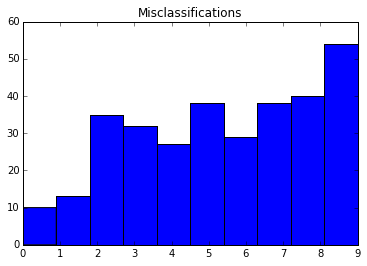

In [9]:
test_mistakes = test_Y.loc[test_Y != test_predictions]
plt.xticks(range(10))
plt.title("Misclassifications")
plt.hist(list(test_mistakes), bins = 10);

It seems that we're classifying 0 and 1 relatively accurately, with our biggest issue being 9. We can construct similar plots to see what we're misclassifying some of these numbers as.

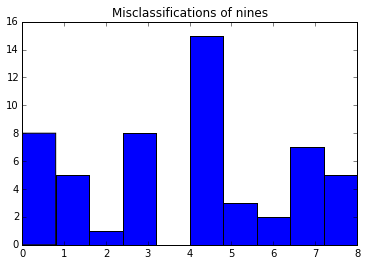

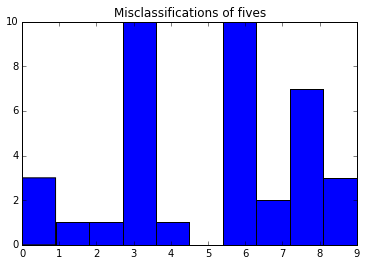

In [10]:
test_predictions = Series(test_predictions)

test_mistakes_nines = test_predictions.loc[(test_Y != test_predictions) & (test_Y == 9)]
plt.figure(0)
plt.xticks(range(10))
plt.title("Misclassifications of nines")
plt.hist(list(test_mistakes_nines), bins = 10);

test_mistakes_fives = test_predictions.loc[(test_Y != test_predictions) & (test_Y == 5)]
plt.figure(1)
plt.xticks(range(10))
plt.title("Misclassifications of fives")
plt.hist(list(test_mistakes_fives), bins = 10);

Unsurprisingly, we see mistakes concentrated between numbers that look similar, such as 5 and 3, and 9 and 4. Beyond that, these graphs suggest that the model does not suffer specific defects. Instead, the model is simply imperfect at distinguishing between edge cases. 